In [2]:
# read the data queried in the last module

from astropy.table import Table
from gala.coordinates import GD1Koposov10

filename = 'gd1_data_05b.hdf5'
table = Table.read(filename, path="transformed")
table.info


<Table length=8053>
        name          dtype    unit                              description                                class     n_bad
-------------------- ------- -------- ------------------------------------------------------------------ ------------ -----
           source_id   int64          Unique source identifier (unique within a particular Data Release) MaskedColumn     0
                  ra float64      deg                                                    Right ascension MaskedColumn     0
                 dec float64      deg                                                        Declination MaskedColumn     0
                pmra float64 mas / yr                         Proper motion in right ascension direction MaskedColumn     0
               pmdec float64 mas / yr                             Proper motion in declination direction MaskedColumn     0
number_of_neighbours   int16                                  Number of neighbours in External Catalogue MaskedC

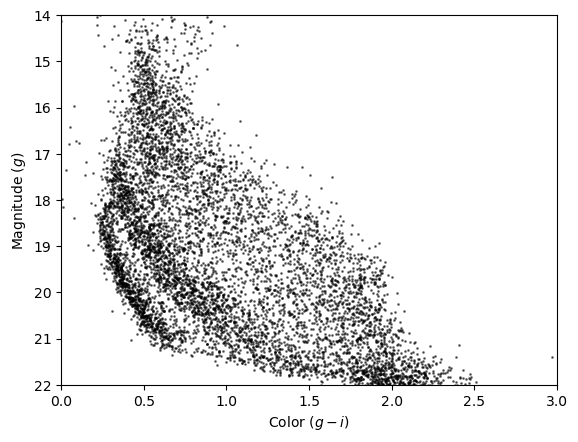

In [3]:
import matplotlib.pyplot as plt

def plot_cmd(table):
    y=table['g_mean_psf_mag']
    x=table['g_mean_psf_mag'] - table['i_mean_psf_mag']

    plt.plot(x,y,'ko', markersize=1, alpha=.5)
    
    plt.xlim(0,3)
    plt.ylim(14,22)
    plt.gca().invert_yaxis()
    
    plt.ylabel('Magnitude $(g)$')
    plt.xlabel('Color $(g-i)$')

plot_cmd(table)

In [4]:
# download a package for reading MIST isochrone data
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/jieunchoi/MIST_codes/raw/master/scripts/' +
         'read_mist_models.py')



In [5]:
# import the package and read the MIST isochrone

import read_mist_models

filename = 'MIST_iso_689d45a79137f.iso.cmd'
iso = read_mist_models.ISOCMD(filename)
iso_array = iso.isocmds[0]

# select stars in main sequence and red giant phases 0<=phase<3
phase = iso_array['phase']
phase_mask = (phase>=0) & (phase<3)
iso_main_sequence = iso_array[phase_mask]
len(iso_main_sequence)

Reading in: MIST_iso_689d45a79137f.iso.cmd


354

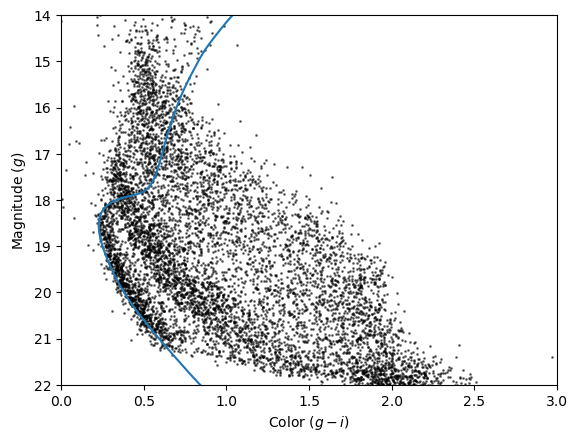

In [6]:
# apply distance modulus to isochrone to scale magnitudes to GD-1

import astropy.coordinates as coord
import astropy.units as u

distance = coord.Distance(7.8 * u.kpc)
distmod =  distance.distmod.value

mag_g = iso_main_sequence['PS_g'] + distmod
color_gi = iso_main_sequence['PS_g'] - iso_main_sequence['PS_i']

isochrone = Table([mag_g, color_gi], names=('mag_g', 'color_gi'))

plot_cmd(table)
plt.plot(color_gi, mag_g)

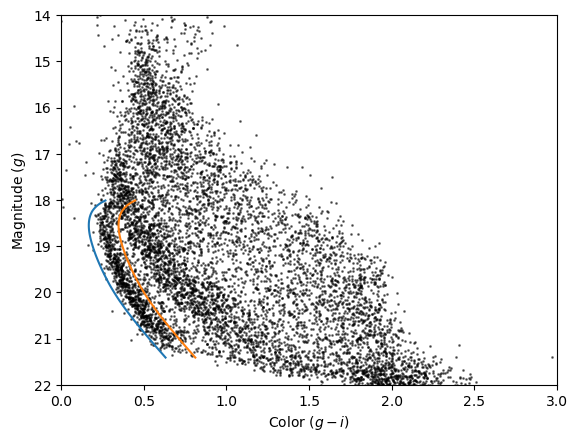

In [7]:
# select the part of the isochrone that lies in the overdense region
mag_g = isochrone['mag_g']
g_mask = (mag_g > 18.0) & (mag_g <21.5)
iso_masked = isochrone[g_mask]

# create a polygon to select a region around the isochrone
color_gi = iso_masked['color_gi']
mag_g = iso_masked['mag_g']
color_left = color_gi - 0.06
color_right = color_gi + 0.12

plot_cmd(table)
plt.plot(color_left, mag_g)
plt.plot(color_right, mag_g)

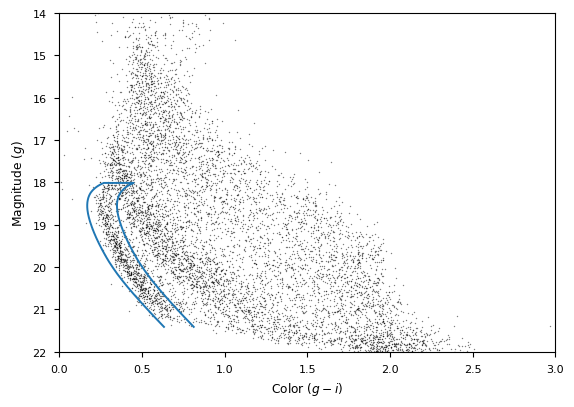

In [8]:
import numpy as np

# we will select stars in the dataset based on the isochrone

# first create a polygon
def polygon (a, b):
    return np.append(a, b[::-1])

color_gi = iso_masked['color_gi']
mag_g = iso_masked['mag_g']

color_polygon = polygon(color_left, color_right)
mag_polygon = polygon(mag_g, mag_g)
polygon = Table([color_polygon, mag_polygon], names=['color_gi', 'mag_g'])

plt.style.use('seaborn-v0_8-paper')
plot_cmd(table)
plt.plot(color_polygon, mag_polygon)

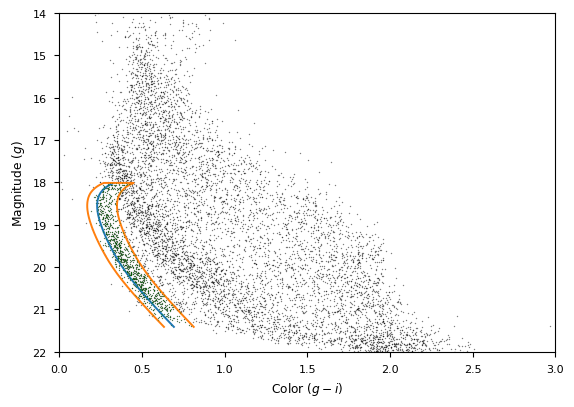

In [16]:
from matplotlib.patches import Polygon
import pandas as pd

poly_tester = Polygon(polygon.to_pandas())

d_mag_g = table['g_mean_psf_mag']
d_color_gi = table['g_mean_psf_mag'] - table['i_mean_psf_mag']

points = pd.DataFrame()

points['color'] = d_color_gi
points['mag'] = d_mag_g

inside = poly_tester.contains_points(points)

winner_table = table[inside]

plot_cmd(table)
plt.plot(color_gi, mag_g)
plt.plot(color_polygon, mag_polygon)

x = winner_table['g_mean_psf_mag'] - winner_table['i_mean_psf_mag']
y = winner_table['g_mean_psf_mag']
plt.plot(x, y, 'go', markersize=0.5, alpha=0.5);


Text(0.5, 1.0, 'High-Confidence GD1 Members (PM and Isochrone Filter)')

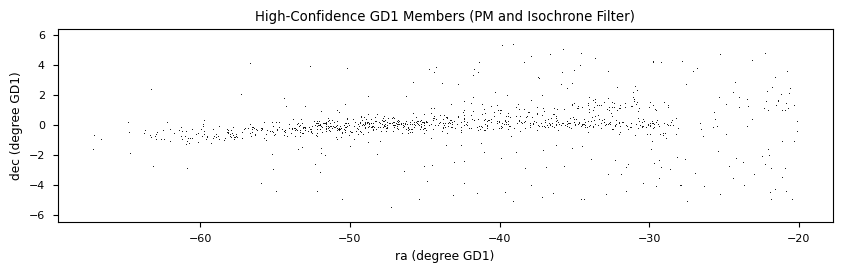

In [22]:
plt.figure(figsize=(10,2.5))

x = winner_table['phi1']
y = winner_table['phi2']
plt.plot(x, y, 'ko', markersize=0.7, alpha=0.9)

plt.xlabel('ra (degree GD1)')
plt.ylabel('dec (degree GD1)')

plt.axis('equal');
plt.title('High-Confidence GD1 Members (PM and Isochrone Filter)')

Text(0.5, 1.0, 'Proper Motion Filtered Candidate Members')

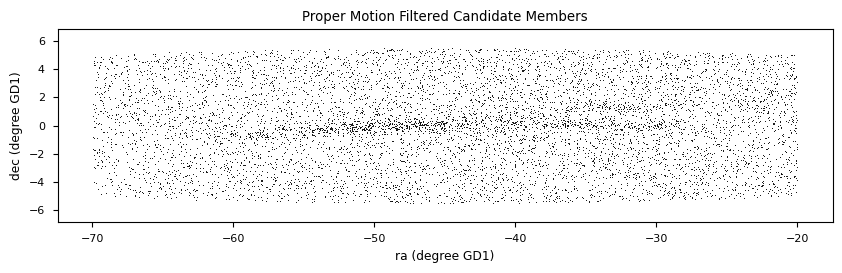

In [24]:
plt.figure(figsize=(10,2.5))

x = table['phi1']
y = table['phi2']
plt.plot(x, y, 'ko', markersize=0.7, alpha=0.9)

plt.xlabel('ra (degree GD1)')
plt.ylabel('dec (degree GD1)')

plt.axis('equal');

plt.title('Proper Motion Filtered Candidate Members')


In [25]:
# save the data

filename = 'gd1_data_06.hdf5'
winner_table.write(filename, path="winner", serialize_meta=True, overwrite=True)

from os.path import getsize

MB = 1024 * 1024
getsize(filename) / MB


0.09827518463134766